In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 16

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 32)   4704        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 32)   128         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 32)     9216        spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 32)     128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 32)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 32)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 32)           0           spatial_dropout2d_9[0][0]        
__________

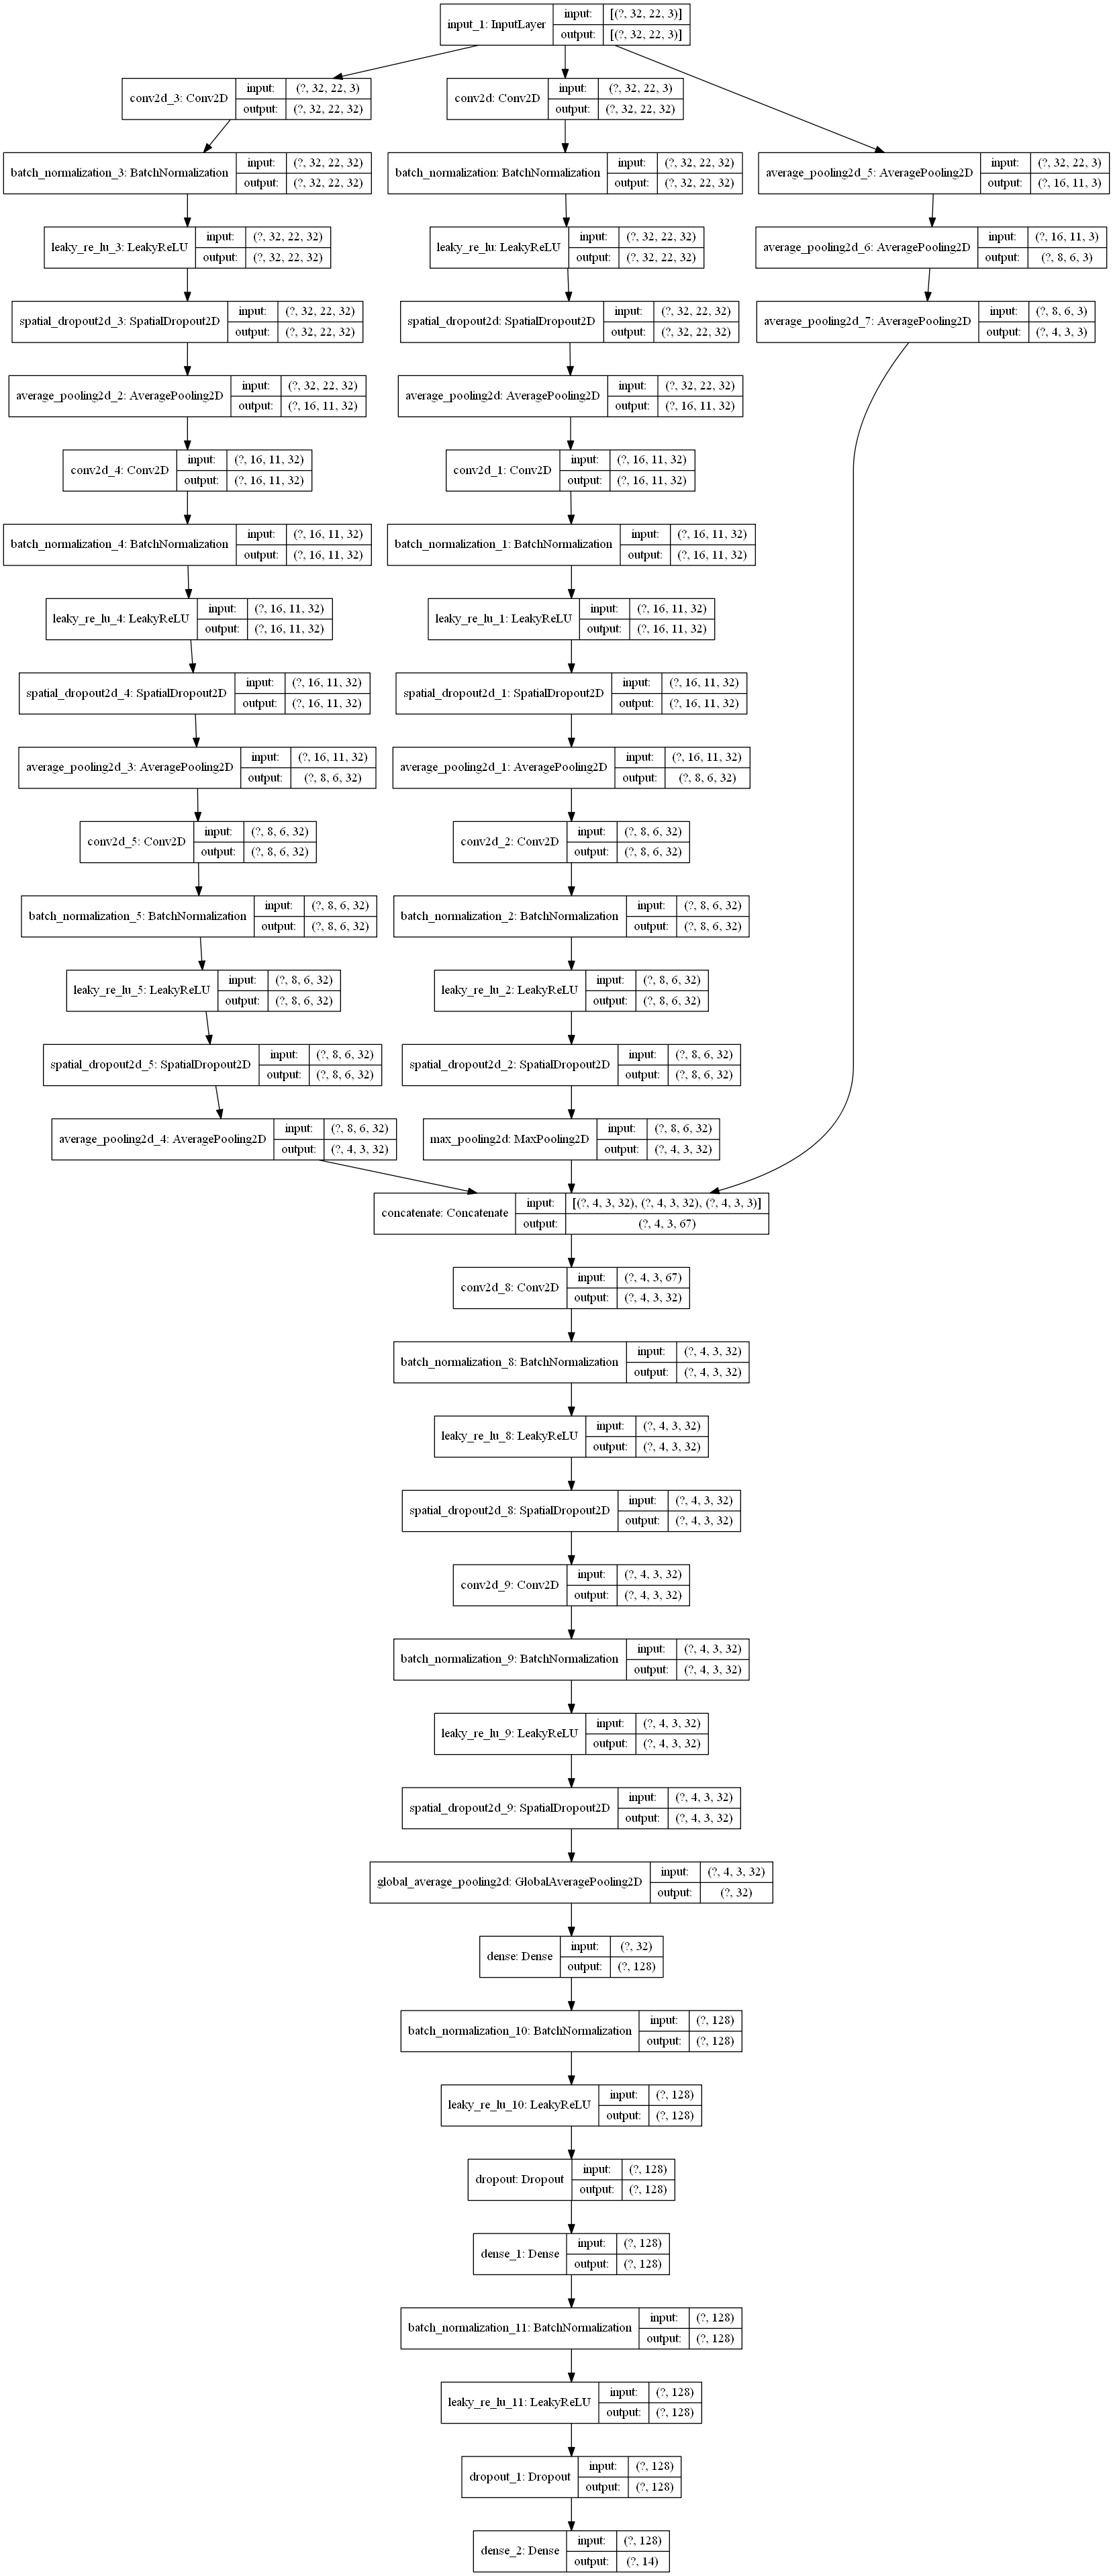

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  2%|█▌                                                                             | 40/1960 [00:00<00:09, 198.84it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 205.77it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 207.85it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:34 - loss: 3.2597 - acc: 0.031 - ETA: 48s - loss: 3.0358 - acc: 0.109 - ETA: 32s - loss: 2.9147 - acc: 0.12 - ETA: 24s - loss: 2.8385 - acc: 0.13 - ETA: 20s - loss: 2.8121 - acc: 0.13 - ETA: 16s - loss: 2.7101 - acc: 0.16 - ETA: 14s - loss: 2.6532 - acc: 0.16 - ETA: 13s - loss: 2.6181 - acc: 0.16 - ETA: 11s - loss: 2.5656 - acc: 0.19 - ETA: 10s - loss: 2.4919 - acc: 0.21 - ETA: 9s - loss: 2.4597 - acc: 0.2216 - ETA: 8s - loss: 2.4318 - acc: 0.218 - ETA: 8s - loss: 2.3787 - acc: 0.235 - ETA: 7s - loss: 2.3503 - acc: 0.238 - ETA: 7s - loss: 2.3402 - acc: 0.245 - ETA: 6s - loss: 2.3121 - acc: 0.240 - ETA: 6s - loss: 2.2831 - acc: 0.242 - ETA: 6s - loss: 2.2477 - acc: 0.253 - ETA: 5s - loss: 2.2088 - acc: 0.273 - ETA: 5s - loss: 2.1904 - acc: 0.279 - ETA: 5s - loss: 2.1747 - acc: 0.281 - ETA: 4s - loss: 2.1611 - acc: 0.288 - ETA: 4s - loss: 2.1439 - acc: 0.290 - ETA: 4s - loss: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.5286 - acc: 0.843 - ETA: 3s - loss: 0.4569 - acc: 0.859 - ETA: 3s - loss: 0.5828 - acc: 0.812 - ETA: 3s - loss: 0.5549 - acc: 0.828 - ETA: 3s - loss: 0.5843 - acc: 0.800 - ETA: 3s - loss: 0.5804 - acc: 0.812 - ETA: 3s - loss: 0.5783 - acc: 0.817 - ETA: 3s - loss: 0.5764 - acc: 0.816 - ETA: 3s - loss: 0.5744 - acc: 0.819 - ETA: 3s - loss: 0.5477 - acc: 0.831 - ETA: 2s - loss: 0.5415 - acc: 0.843 - ETA: 2s - loss: 0.5466 - acc: 0.835 - ETA: 2s - loss: 0.5720 - acc: 0.831 - ETA: 2s - loss: 0.5632 - acc: 0.832 - ETA: 2s - loss: 0.5585 - acc: 0.829 - ETA: 2s - loss: 0.5558 - acc: 0.826 - ETA: 2s - loss: 0.5665 - acc: 0.816 - ETA: 2s - loss: 0.5770 - acc: 0.814 - ETA: 2s - loss: 0.5690 - acc: 0.815 - ETA: 2s - loss: 0.5734 - acc: 0.812 - ETA: 2s - loss: 0.5671 - acc: 0.814 - ETA: 2s - loss: 0.5717 - acc: 0.815 - ETA: 2s - loss: 0.5680 - acc: 0.817 - ETA: 2s - loss: 0.5732 - acc: 0.816 - ETA: 2s - loss: 0.5727 - acc: 0.818 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2732 - acc: 0.937 - ETA: 3s - loss: 0.3394 - acc: 0.875 - ETA: 3s - loss: 0.4376 - acc: 0.875 - ETA: 3s - loss: 0.3949 - acc: 0.882 - ETA: 3s - loss: 0.4318 - acc: 0.868 - ETA: 3s - loss: 0.4479 - acc: 0.859 - ETA: 3s - loss: 0.4850 - acc: 0.848 - ETA: 3s - loss: 0.5346 - acc: 0.839 - ETA: 2s - loss: 0.5451 - acc: 0.836 - ETA: 2s - loss: 0.5290 - acc: 0.840 - ETA: 2s - loss: 0.5261 - acc: 0.840 - ETA: 2s - loss: 0.5245 - acc: 0.838 - ETA: 2s - loss: 0.5301 - acc: 0.834 - ETA: 2s - loss: 0.5572 - acc: 0.823 - ETA: 2s - loss: 0.5447 - acc: 0.827 - ETA: 2s - loss: 0.5476 - acc: 0.822 - ETA: 2s - loss: 0.5428 - acc: 0.823 - ETA: 2s - loss: 0.5291 - acc: 0.828 - ETA: 2s - loss: 0.5237 - acc: 0.828 - ETA: 2s - loss: 0.5299 - acc: 0.823 - ETA: 2s - loss: 0.5229 - acc: 0.822 - ETA: 2s - loss: 0.5204 - acc: 0.825 - ETA: 2s - loss: 0.5157 - acc: 0.826 - ETA: 2s - loss: 0.5112 - acc: 0.828 - ETA: 2s - loss: 0.4995 - acc: 0.831 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1931 - acc: 0.968 - ETA: 3s - loss: 0.1580 - acc: 0.968 - ETA: 3s - loss: 0.2254 - acc: 0.947 - ETA: 3s - loss: 0.2440 - acc: 0.945 - ETA: 3s - loss: 0.2386 - acc: 0.943 - ETA: 3s - loss: 0.2757 - acc: 0.932 - ETA: 3s - loss: 0.2813 - acc: 0.915 - ETA: 2s - loss: 0.2787 - acc: 0.918 - ETA: 2s - loss: 0.2644 - acc: 0.923 - ETA: 2s - loss: 0.2865 - acc: 0.915 - ETA: 2s - loss: 0.2902 - acc: 0.917 - ETA: 2s - loss: 0.2907 - acc: 0.914 - ETA: 2s - loss: 0.3117 - acc: 0.908 - ETA: 2s - loss: 0.3159 - acc: 0.908 - ETA: 2s - loss: 0.3264 - acc: 0.910 - ETA: 2s - loss: 0.3344 - acc: 0.906 - ETA: 2s - loss: 0.3347 - acc: 0.902 - ETA: 2s - loss: 0.3365 - acc: 0.902 - ETA: 2s - loss: 0.3384 - acc: 0.901 - ETA: 2s - loss: 0.3375 - acc: 0.903 - ETA: 2s - loss: 0.3476 - acc: 0.897 - ETA: 2s - loss: 0.3502 - acc: 0.899 - ETA: 2s - loss: 0.3466 - acc: 0.898 - ETA: 2s - loss: 0.3463 - acc: 0.898 - ETA: 2s - loss: 0.3614 - acc: 0.896 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1977 - acc: 0.937 - ETA: 3s - loss: 0.2083 - acc: 0.937 - ETA: 3s - loss: 0.2015 - acc: 0.947 - ETA: 3s - loss: 0.2281 - acc: 0.929 - ETA: 3s - loss: 0.2115 - acc: 0.943 - ETA: 3s - loss: 0.2394 - acc: 0.932 - ETA: 3s - loss: 0.2483 - acc: 0.924 - ETA: 2s - loss: 0.2545 - acc: 0.921 - ETA: 2s - loss: 0.2648 - acc: 0.920 - ETA: 2s - loss: 0.2651 - acc: 0.915 - ETA: 2s - loss: 0.2635 - acc: 0.914 - ETA: 2s - loss: 0.2898 - acc: 0.914 - ETA: 2s - loss: 0.2902 - acc: 0.913 - ETA: 2s - loss: 0.2835 - acc: 0.917 - ETA: 2s - loss: 0.2983 - acc: 0.914 - ETA: 2s - loss: 0.2951 - acc: 0.914 - ETA: 2s - loss: 0.2871 - acc: 0.913 - ETA: 2s - loss: 0.2807 - acc: 0.916 - ETA: 2s - loss: 0.2736 - acc: 0.919 - ETA: 2s - loss: 0.2748 - acc: 0.920 - ETA: 2s - loss: 0.2824 - acc: 0.918 - ETA: 2s - loss: 0.2778 - acc: 0.919 - ETA: 2s - loss: 0.2733 - acc: 0.921 - ETA: 2s - loss: 0.2775 - acc: 0.921 - ETA: 1s - loss: 0.2794 - acc: 0.920 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0920 - acc: 0.968 - ETA: 3s - loss: 0.0999 - acc: 0.984 - ETA: 3s - loss: 0.1041 - acc: 0.989 - ETA: 3s - loss: 0.1252 - acc: 0.992 - ETA: 3s - loss: 0.1400 - acc: 0.981 - ETA: 3s - loss: 0.1492 - acc: 0.974 - ETA: 3s - loss: 0.2085 - acc: 0.955 - ETA: 3s - loss: 0.1943 - acc: 0.960 - ETA: 2s - loss: 0.2183 - acc: 0.954 - ETA: 2s - loss: 0.2288 - acc: 0.946 - ETA: 2s - loss: 0.2265 - acc: 0.948 - ETA: 2s - loss: 0.2191 - acc: 0.950 - ETA: 2s - loss: 0.2268 - acc: 0.942 - ETA: 2s - loss: 0.2287 - acc: 0.939 - ETA: 2s - loss: 0.2331 - acc: 0.937 - ETA: 2s - loss: 0.2459 - acc: 0.933 - ETA: 2s - loss: 0.2457 - acc: 0.932 - ETA: 2s - loss: 0.2487 - acc: 0.930 - ETA: 2s - loss: 0.2429 - acc: 0.932 - ETA: 2s - loss: 0.2442 - acc: 0.931 - ETA: 2s - loss: 0.2383 - acc: 0.933 - ETA: 2s - loss: 0.2386 - acc: 0.931 - ETA: 2s - loss: 0.2429 - acc: 0.930 - ETA: 2s - loss: 0.2390 - acc: 0.932 - ETA: 2s - loss: 0.2338 - acc: 0.933 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1554 - acc: 0.937 - ETA: 3s - loss: 0.1771 - acc: 0.921 - ETA: 3s - loss: 0.2488 - acc: 0.927 - ETA: 3s - loss: 0.2207 - acc: 0.937 - ETA: 3s - loss: 0.2397 - acc: 0.937 - ETA: 2s - loss: 0.2406 - acc: 0.932 - ETA: 2s - loss: 0.2740 - acc: 0.928 - ETA: 2s - loss: 0.2574 - acc: 0.933 - ETA: 2s - loss: 0.2431 - acc: 0.934 - ETA: 2s - loss: 0.2294 - acc: 0.937 - ETA: 2s - loss: 0.2341 - acc: 0.937 - ETA: 2s - loss: 0.2389 - acc: 0.932 - ETA: 2s - loss: 0.2471 - acc: 0.932 - ETA: 2s - loss: 0.2676 - acc: 0.928 - ETA: 2s - loss: 0.2572 - acc: 0.931 - ETA: 2s - loss: 0.2572 - acc: 0.929 - ETA: 2s - loss: 0.2480 - acc: 0.933 - ETA: 2s - loss: 0.2469 - acc: 0.934 - ETA: 2s - loss: 0.2414 - acc: 0.935 - ETA: 2s - loss: 0.2389 - acc: 0.935 - ETA: 2s - loss: 0.2341 - acc: 0.936 - ETA: 2s - loss: 0.2272 - acc: 0.937 - ETA: 2s - loss: 0.2267 - acc: 0.937 - ETA: 2s - loss: 0.2228 - acc: 0.937 - ETA: 2s - loss: 0.2248 - acc: 0.936 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0358 - acc: 1.000 - ETA: 3s - loss: 0.3097 - acc: 0.921 - ETA: 3s - loss: 0.3343 - acc: 0.916 - ETA: 3s - loss: 0.2622 - acc: 0.937 - ETA: 3s - loss: 0.2317 - acc: 0.950 - ETA: 2s - loss: 0.2427 - acc: 0.942 - ETA: 2s - loss: 0.2422 - acc: 0.937 - ETA: 2s - loss: 0.2336 - acc: 0.937 - ETA: 2s - loss: 0.2277 - acc: 0.941 - ETA: 2s - loss: 0.2136 - acc: 0.946 - ETA: 2s - loss: 0.2128 - acc: 0.948 - ETA: 2s - loss: 0.2149 - acc: 0.945 - ETA: 2s - loss: 0.2044 - acc: 0.947 - ETA: 2s - loss: 0.1950 - acc: 0.948 - ETA: 2s - loss: 0.1900 - acc: 0.950 - ETA: 2s - loss: 0.1845 - acc: 0.951 - ETA: 2s - loss: 0.1803 - acc: 0.952 - ETA: 2s - loss: 0.1812 - acc: 0.951 - ETA: 2s - loss: 0.1883 - acc: 0.949 - ETA: 2s - loss: 0.1835 - acc: 0.950 - ETA: 2s - loss: 0.1936 - acc: 0.946 - ETA: 2s - loss: 0.1923 - acc: 0.947 - ETA: 2s - loss: 0.1913 - acc: 0.948 - ETA: 2s - loss: 0.1892 - acc: 0.947 - ETA: 1s - loss: 0.1875 - acc: 0.947 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2433 - acc: 0.875 - ETA: 3s - loss: 0.1451 - acc: 0.937 - ETA: 3s - loss: 0.1403 - acc: 0.947 - ETA: 3s - loss: 0.1169 - acc: 0.960 - ETA: 3s - loss: 0.1494 - acc: 0.950 - ETA: 2s - loss: 0.1402 - acc: 0.953 - ETA: 2s - loss: 0.1362 - acc: 0.950 - ETA: 2s - loss: 0.1250 - acc: 0.957 - ETA: 2s - loss: 0.1276 - acc: 0.958 - ETA: 2s - loss: 0.1331 - acc: 0.953 - ETA: 2s - loss: 0.1293 - acc: 0.951 - ETA: 2s - loss: 0.1231 - acc: 0.955 - ETA: 2s - loss: 0.1174 - acc: 0.956 - ETA: 2s - loss: 0.1198 - acc: 0.955 - ETA: 2s - loss: 0.1196 - acc: 0.956 - ETA: 2s - loss: 0.1179 - acc: 0.959 - ETA: 2s - loss: 0.1132 - acc: 0.961 - ETA: 2s - loss: 0.1188 - acc: 0.956 - ETA: 2s - loss: 0.1280 - acc: 0.955 - ETA: 2s - loss: 0.1248 - acc: 0.956 - ETA: 2s - loss: 0.1241 - acc: 0.956 - ETA: 2s - loss: 0.1246 - acc: 0.957 - ETA: 2s - loss: 0.1219 - acc: 0.957 - ETA: 2s - loss: 0.1208 - acc: 0.958 - ETA: 1s - loss: 0.1338 - acc: 0.956 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0772 - acc: 0.968 - ETA: 3s - loss: 0.0625 - acc: 0.968 - ETA: 3s - loss: 0.1440 - acc: 0.947 - ETA: 3s - loss: 0.1309 - acc: 0.953 - ETA: 3s - loss: 0.1151 - acc: 0.956 - ETA: 3s - loss: 0.1029 - acc: 0.963 - ETA: 2s - loss: 0.1063 - acc: 0.964 - ETA: 2s - loss: 0.1218 - acc: 0.960 - ETA: 2s - loss: 0.1155 - acc: 0.961 - ETA: 2s - loss: 0.1198 - acc: 0.956 - ETA: 2s - loss: 0.1456 - acc: 0.946 - ETA: 2s - loss: 0.1400 - acc: 0.950 - ETA: 2s - loss: 0.1472 - acc: 0.947 - ETA: 2s - loss: 0.1477 - acc: 0.944 - ETA: 2s - loss: 0.1417 - acc: 0.947 - ETA: 2s - loss: 0.1351 - acc: 0.951 - ETA: 2s - loss: 0.1342 - acc: 0.948 - ETA: 2s - loss: 0.1280 - acc: 0.951 - ETA: 2s - loss: 0.1349 - acc: 0.950 - ETA: 2s - loss: 0.1415 - acc: 0.946 - ETA: 2s - loss: 0.1458 - acc: 0.944 - ETA: 2s - loss: 0.1422 - acc: 0.946 - ETA: 2s - loss: 0.1375 - acc: 0.948 - ETA: 2s - loss: 0.1374 - acc: 0.947 - ETA: 1s - loss: 0.1405 - acc: 0.947 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0301 - acc: 1.000 - ETA: 3s - loss: 0.0282 - acc: 1.000 - ETA: 3s - loss: 0.0675 - acc: 0.979 - ETA: 3s - loss: 0.0812 - acc: 0.976 - ETA: 3s - loss: 0.1172 - acc: 0.968 - ETA: 3s - loss: 0.1363 - acc: 0.963 - ETA: 3s - loss: 0.1341 - acc: 0.964 - ETA: 3s - loss: 0.1258 - acc: 0.964 - ETA: 2s - loss: 0.1253 - acc: 0.961 - ETA: 2s - loss: 0.1194 - acc: 0.962 - ETA: 2s - loss: 0.1145 - acc: 0.963 - ETA: 2s - loss: 0.1132 - acc: 0.960 - ETA: 2s - loss: 0.1172 - acc: 0.959 - ETA: 2s - loss: 0.1265 - acc: 0.955 - ETA: 2s - loss: 0.1280 - acc: 0.954 - ETA: 2s - loss: 0.1382 - acc: 0.951 - ETA: 2s - loss: 0.1433 - acc: 0.946 - ETA: 2s - loss: 0.1424 - acc: 0.947 - ETA: 2s - loss: 0.1423 - acc: 0.947 - ETA: 2s - loss: 0.1491 - acc: 0.948 - ETA: 2s - loss: 0.1443 - acc: 0.949 - ETA: 2s - loss: 0.1414 - acc: 0.950 - ETA: 2s - loss: 0.1446 - acc: 0.949 - ETA: 2s - loss: 0.1427 - acc: 0.950 - ETA: 2s - loss: 0.1420 - acc: 0.950 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0804 - acc: 1.000 - ETA: 3s - loss: 0.0505 - acc: 1.000 - ETA: 3s - loss: 0.0441 - acc: 1.000 - ETA: 3s - loss: 0.0440 - acc: 1.000 - ETA: 3s - loss: 0.0430 - acc: 1.000 - ETA: 3s - loss: 0.0483 - acc: 0.994 - ETA: 3s - loss: 0.0456 - acc: 0.995 - ETA: 2s - loss: 0.0427 - acc: 0.996 - ETA: 2s - loss: 0.0407 - acc: 0.996 - ETA: 2s - loss: 0.0386 - acc: 0.996 - ETA: 2s - loss: 0.0405 - acc: 0.994 - ETA: 2s - loss: 0.0423 - acc: 0.994 - ETA: 2s - loss: 0.0518 - acc: 0.990 - ETA: 2s - loss: 0.0591 - acc: 0.986 - ETA: 2s - loss: 0.0643 - acc: 0.983 - ETA: 2s - loss: 0.0686 - acc: 0.980 - ETA: 2s - loss: 0.0690 - acc: 0.977 - ETA: 2s - loss: 0.0685 - acc: 0.977 - ETA: 2s - loss: 0.0654 - acc: 0.978 - ETA: 2s - loss: 0.0664 - acc: 0.978 - ETA: 2s - loss: 0.0640 - acc: 0.979 - ETA: 2s - loss: 0.0710 - acc: 0.977 - ETA: 2s - loss: 0.0692 - acc: 0.978 - ETA: 2s - loss: 0.0677 - acc: 0.979 - ETA: 1s - loss: 0.0664 - acc: 0.980 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0637 - acc: 0.968 - ETA: 3s - loss: 0.0974 - acc: 0.968 - ETA: 3s - loss: 0.0726 - acc: 0.979 - ETA: 3s - loss: 0.0699 - acc: 0.976 - ETA: 3s - loss: 0.0871 - acc: 0.975 - ETA: 3s - loss: 0.0752 - acc: 0.979 - ETA: 3s - loss: 0.0828 - acc: 0.973 - ETA: 3s - loss: 0.0838 - acc: 0.972 - ETA: 2s - loss: 0.0760 - acc: 0.975 - ETA: 2s - loss: 0.0702 - acc: 0.978 - ETA: 2s - loss: 0.0732 - acc: 0.974 - ETA: 2s - loss: 0.0723 - acc: 0.974 - ETA: 2s - loss: 0.0724 - acc: 0.973 - ETA: 2s - loss: 0.0703 - acc: 0.973 - ETA: 2s - loss: 0.0684 - acc: 0.972 - ETA: 2s - loss: 0.0656 - acc: 0.974 - ETA: 2s - loss: 0.0626 - acc: 0.976 - ETA: 2s - loss: 0.0607 - acc: 0.977 - ETA: 2s - loss: 0.0596 - acc: 0.978 - ETA: 2s - loss: 0.0583 - acc: 0.979 - ETA: 2s - loss: 0.0588 - acc: 0.979 - ETA: 2s - loss: 0.0576 - acc: 0.980 - ETA: 2s - loss: 0.0572 - acc: 0.979 - ETA: 2s - loss: 0.0629 - acc: 0.975 - ETA: 2s - loss: 0.0691 - acc: 0.971 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0169 - acc: 1.000 - ETA: 3s - loss: 0.0582 - acc: 0.984 - ETA: 3s - loss: 0.0687 - acc: 0.979 - ETA: 3s - loss: 0.0588 - acc: 0.984 - ETA: 3s - loss: 0.0619 - acc: 0.981 - ETA: 3s - loss: 0.1073 - acc: 0.974 - ETA: 3s - loss: 0.1175 - acc: 0.973 - ETA: 3s - loss: 0.1056 - acc: 0.976 - ETA: 3s - loss: 0.1240 - acc: 0.972 - ETA: 3s - loss: 0.1155 - acc: 0.975 - ETA: 2s - loss: 0.1148 - acc: 0.974 - ETA: 2s - loss: 0.1093 - acc: 0.974 - ETA: 2s - loss: 0.1129 - acc: 0.971 - ETA: 2s - loss: 0.1106 - acc: 0.971 - ETA: 2s - loss: 0.1077 - acc: 0.970 - ETA: 2s - loss: 0.1023 - acc: 0.972 - ETA: 2s - loss: 0.1020 - acc: 0.972 - ETA: 2s - loss: 0.1002 - acc: 0.972 - ETA: 2s - loss: 0.1027 - acc: 0.972 - ETA: 2s - loss: 0.0986 - acc: 0.973 - ETA: 2s - loss: 0.0995 - acc: 0.971 - ETA: 2s - loss: 0.0963 - acc: 0.973 - ETA: 2s - loss: 0.0950 - acc: 0.972 - ETA: 2s - loss: 0.0923 - acc: 0.974 - ETA: 2s - loss: 0.0890 - acc: 0.975 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0297 - acc: 1.000 - ETA: 3s - loss: 0.0219 - acc: 1.000 - ETA: 3s - loss: 0.0207 - acc: 1.000 - ETA: 3s - loss: 0.0189 - acc: 1.000 - ETA: 3s - loss: 0.0236 - acc: 0.993 - ETA: 3s - loss: 0.0308 - acc: 0.984 - ETA: 3s - loss: 0.0484 - acc: 0.982 - ETA: 3s - loss: 0.0437 - acc: 0.984 - ETA: 3s - loss: 0.0750 - acc: 0.979 - ETA: 2s - loss: 0.0708 - acc: 0.981 - ETA: 2s - loss: 0.0785 - acc: 0.977 - ETA: 2s - loss: 0.0739 - acc: 0.979 - ETA: 2s - loss: 0.0717 - acc: 0.980 - ETA: 2s - loss: 0.0727 - acc: 0.979 - ETA: 2s - loss: 0.0697 - acc: 0.981 - ETA: 2s - loss: 0.0833 - acc: 0.976 - ETA: 2s - loss: 0.0805 - acc: 0.977 - ETA: 2s - loss: 0.0777 - acc: 0.979 - ETA: 2s - loss: 0.0743 - acc: 0.980 - ETA: 2s - loss: 0.0744 - acc: 0.979 - ETA: 2s - loss: 0.0742 - acc: 0.977 - ETA: 2s - loss: 0.0717 - acc: 0.978 - ETA: 2s - loss: 0.0702 - acc: 0.979 - ETA: 2s - loss: 0.0696 - acc: 0.980 - ETA: 2s - loss: 0.0686 - acc: 0.981 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0276 - acc: 1.000 - ETA: 3s - loss: 0.0284 - acc: 1.000 - ETA: 3s - loss: 0.0308 - acc: 0.989 - ETA: 3s - loss: 0.0262 - acc: 0.992 - ETA: 3s - loss: 0.0416 - acc: 0.987 - ETA: 3s - loss: 0.0361 - acc: 0.989 - ETA: 2s - loss: 0.0381 - acc: 0.986 - ETA: 2s - loss: 0.0353 - acc: 0.988 - ETA: 2s - loss: 0.0380 - acc: 0.982 - ETA: 2s - loss: 0.0445 - acc: 0.981 - ETA: 2s - loss: 0.0446 - acc: 0.980 - ETA: 2s - loss: 0.0417 - acc: 0.981 - ETA: 2s - loss: 0.0392 - acc: 0.983 - ETA: 2s - loss: 0.0466 - acc: 0.982 - ETA: 2s - loss: 0.0441 - acc: 0.983 - ETA: 2s - loss: 0.0458 - acc: 0.982 - ETA: 2s - loss: 0.0439 - acc: 0.983 - ETA: 2s - loss: 0.0424 - acc: 0.984 - ETA: 2s - loss: 0.0423 - acc: 0.985 - ETA: 2s - loss: 0.0427 - acc: 0.985 - ETA: 2s - loss: 0.0413 - acc: 0.986 - ETA: 2s - loss: 0.0410 - acc: 0.987 - ETA: 2s - loss: 0.0446 - acc: 0.986 - ETA: 2s - loss: 0.0443 - acc: 0.985 - ETA: 1s - loss: 0.0433 - acc: 0.986 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0125 - acc: 1.000 - ETA: 3s - loss: 0.0230 - acc: 1.000 - ETA: 3s - loss: 0.0239 - acc: 1.000 - ETA: 3s - loss: 0.0521 - acc: 0.976 - ETA: 3s - loss: 0.0524 - acc: 0.975 - ETA: 2s - loss: 0.0450 - acc: 0.979 - ETA: 2s - loss: 0.0415 - acc: 0.982 - ETA: 2s - loss: 0.0414 - acc: 0.980 - ETA: 2s - loss: 0.0396 - acc: 0.982 - ETA: 2s - loss: 0.0363 - acc: 0.984 - ETA: 2s - loss: 0.0392 - acc: 0.983 - ETA: 2s - loss: 0.0382 - acc: 0.984 - ETA: 2s - loss: 0.0463 - acc: 0.983 - ETA: 2s - loss: 0.0435 - acc: 0.984 - ETA: 2s - loss: 0.0414 - acc: 0.985 - ETA: 2s - loss: 0.0403 - acc: 0.986 - ETA: 2s - loss: 0.0404 - acc: 0.985 - ETA: 2s - loss: 0.0498 - acc: 0.984 - ETA: 2s - loss: 0.0550 - acc: 0.983 - ETA: 2s - loss: 0.0535 - acc: 0.984 - ETA: 2s - loss: 0.0551 - acc: 0.983 - ETA: 2s - loss: 0.0573 - acc: 0.983 - ETA: 2s - loss: 0.0552 - acc: 0.983 - ETA: 2s - loss: 0.0536 - acc: 0.984 - ETA: 1s - loss: 0.0625 - acc: 0.982 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0218 - acc: 1.000 - ETA: 3s - loss: 0.0189 - acc: 1.000 - ETA: 3s - loss: 0.0246 - acc: 1.000 - ETA: 3s - loss: 0.0227 - acc: 1.000 - ETA: 2s - loss: 0.0327 - acc: 0.993 - ETA: 2s - loss: 0.0342 - acc: 0.994 - ETA: 2s - loss: 0.0467 - acc: 0.991 - ETA: 2s - loss: 0.0433 - acc: 0.992 - ETA: 2s - loss: 0.0390 - acc: 0.993 - ETA: 2s - loss: 0.0368 - acc: 0.993 - ETA: 2s - loss: 0.0446 - acc: 0.988 - ETA: 2s - loss: 0.0573 - acc: 0.981 - ETA: 2s - loss: 0.0544 - acc: 0.983 - ETA: 2s - loss: 0.0551 - acc: 0.982 - ETA: 2s - loss: 0.0519 - acc: 0.983 - ETA: 2s - loss: 0.0491 - acc: 0.984 - ETA: 2s - loss: 0.0533 - acc: 0.983 - ETA: 2s - loss: 0.0563 - acc: 0.982 - ETA: 2s - loss: 0.0611 - acc: 0.981 - ETA: 2s - loss: 0.0590 - acc: 0.982 - ETA: 2s - loss: 0.0570 - acc: 0.983 - ETA: 2s - loss: 0.0566 - acc: 0.984 - ETA: 2s - loss: 0.0569 - acc: 0.983 - ETA: 2s - loss: 0.0589 - acc: 0.983 - ETA: 1s - loss: 0.0632 - acc: 0.982 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0104 - acc: 1.000 - ETA: 3s - loss: 0.0452 - acc: 0.984 - ETA: 3s - loss: 0.0425 - acc: 0.979 - ETA: 3s - loss: 0.0430 - acc: 0.976 - ETA: 3s - loss: 0.0415 - acc: 0.981 - ETA: 2s - loss: 0.0367 - acc: 0.984 - ETA: 2s - loss: 0.0341 - acc: 0.986 - ETA: 2s - loss: 0.0334 - acc: 0.984 - ETA: 2s - loss: 0.0306 - acc: 0.986 - ETA: 2s - loss: 0.0281 - acc: 0.987 - ETA: 2s - loss: 0.0269 - acc: 0.988 - ETA: 2s - loss: 0.0331 - acc: 0.987 - ETA: 2s - loss: 0.0309 - acc: 0.988 - ETA: 2s - loss: 0.0306 - acc: 0.988 - ETA: 2s - loss: 0.0305 - acc: 0.989 - ETA: 2s - loss: 0.0297 - acc: 0.990 - ETA: 2s - loss: 0.0305 - acc: 0.989 - ETA: 2s - loss: 0.0291 - acc: 0.989 - ETA: 2s - loss: 0.0279 - acc: 0.990 - ETA: 2s - loss: 0.0315 - acc: 0.989 - ETA: 2s - loss: 0.0339 - acc: 0.988 - ETA: 2s - loss: 0.0336 - acc: 0.988 - ETA: 2s - loss: 0.0346 - acc: 0.987 - ETA: 2s - loss: 0.0372 - acc: 0.987 - ETA: 1s - loss: 0.0369 - acc: 0.987 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0174 - acc: 1.000 - ETA: 3s - loss: 0.0671 - acc: 0.989 - ETA: 3s - loss: 0.0719 - acc: 0.984 - ETA: 3s - loss: 0.0609 - acc: 0.987 - ETA: 3s - loss: 0.0527 - acc: 0.989 - ETA: 3s - loss: 0.0485 - acc: 0.991 - ETA: 3s - loss: 0.0455 - acc: 0.992 - ETA: 3s - loss: 0.0430 - acc: 0.993 - ETA: 3s - loss: 0.0578 - acc: 0.987 - ETA: 2s - loss: 0.0607 - acc: 0.985 - ETA: 2s - loss: 0.0604 - acc: 0.984 - ETA: 2s - loss: 0.0596 - acc: 0.983 - ETA: 2s - loss: 0.0559 - acc: 0.984 - ETA: 2s - loss: 0.0532 - acc: 0.985 - ETA: 2s - loss: 0.0513 - acc: 0.986 - ETA: 2s - loss: 0.0511 - acc: 0.985 - ETA: 2s - loss: 0.0486 - acc: 0.986 - ETA: 2s - loss: 0.0471 - acc: 0.986 - ETA: 2s - loss: 0.0480 - acc: 0.985 - ETA: 2s - loss: 0.0522 - acc: 0.985 - ETA: 2s - loss: 0.0500 - acc: 0.985 - ETA: 2s - loss: 0.0494 - acc: 0.986 - ETA: 2s - loss: 0.0489 - acc: 0.987 - ETA: 2s - loss: 0.0472 - acc: 0.987 - ETA: 2s - loss: 0.0464 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0070 - acc: 1.000 - ETA: 3s - loss: 0.0128 - acc: 1.000 - ETA: 3s - loss: 0.0166 - acc: 1.000 - ETA: 3s - loss: 0.0184 - acc: 1.000 - ETA: 3s - loss: 0.0177 - acc: 1.000 - ETA: 2s - loss: 0.0203 - acc: 1.000 - ETA: 2s - loss: 0.0195 - acc: 1.000 - ETA: 2s - loss: 0.0224 - acc: 0.996 - ETA: 2s - loss: 0.0261 - acc: 0.993 - ETA: 2s - loss: 0.0392 - acc: 0.987 - ETA: 2s - loss: 0.0359 - acc: 0.988 - ETA: 2s - loss: 0.0367 - acc: 0.987 - ETA: 2s - loss: 0.0357 - acc: 0.988 - ETA: 2s - loss: 0.0369 - acc: 0.986 - ETA: 2s - loss: 0.0361 - acc: 0.987 - ETA: 2s - loss: 0.0416 - acc: 0.986 - ETA: 2s - loss: 0.0410 - acc: 0.987 - ETA: 2s - loss: 0.0390 - acc: 0.987 - ETA: 2s - loss: 0.0385 - acc: 0.988 - ETA: 2s - loss: 0.0372 - acc: 0.989 - ETA: 2s - loss: 0.0368 - acc: 0.989 - ETA: 2s - loss: 0.0355 - acc: 0.990 - ETA: 2s - loss: 0.0342 - acc: 0.990 - ETA: 2s - loss: 0.0365 - acc: 0.989 - ETA: 1s - loss: 0.0414 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0205 - acc: 1.000 - ETA: 3s - loss: 0.0136 - acc: 1.000 - ETA: 3s - loss: 0.0680 - acc: 0.989 - ETA: 3s - loss: 0.0535 - acc: 0.992 - ETA: 3s - loss: 0.0483 - acc: 0.993 - ETA: 3s - loss: 0.0564 - acc: 0.984 - ETA: 3s - loss: 0.0508 - acc: 0.986 - ETA: 3s - loss: 0.0458 - acc: 0.988 - ETA: 3s - loss: 0.0548 - acc: 0.986 - ETA: 2s - loss: 0.0563 - acc: 0.984 - ETA: 2s - loss: 0.0555 - acc: 0.983 - ETA: 2s - loss: 0.0583 - acc: 0.981 - ETA: 2s - loss: 0.0553 - acc: 0.983 - ETA: 2s - loss: 0.0528 - acc: 0.984 - ETA: 2s - loss: 0.0508 - acc: 0.985 - ETA: 2s - loss: 0.0479 - acc: 0.986 - ETA: 2s - loss: 0.0454 - acc: 0.987 - ETA: 2s - loss: 0.0438 - acc: 0.987 - ETA: 2s - loss: 0.0432 - acc: 0.988 - ETA: 2s - loss: 0.0426 - acc: 0.989 - ETA: 2s - loss: 0.0410 - acc: 0.989 - ETA: 2s - loss: 0.0398 - acc: 0.990 - ETA: 2s - loss: 0.0398 - acc: 0.989 - ETA: 2s - loss: 0.0421 - acc: 0.987 - ETA: 2s - loss: 0.0413 - acc: 0.987 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0684 - acc: 0.968 - ETA: 3s - loss: 0.0361 - acc: 0.984 - ETA: 3s - loss: 0.0281 - acc: 0.989 - ETA: 3s - loss: 0.0570 - acc: 0.984 - ETA: 3s - loss: 0.0590 - acc: 0.981 - ETA: 3s - loss: 0.0531 - acc: 0.984 - ETA: 3s - loss: 0.0470 - acc: 0.986 - ETA: 3s - loss: 0.0634 - acc: 0.984 - ETA: 2s - loss: 0.0576 - acc: 0.986 - ETA: 2s - loss: 0.0540 - acc: 0.987 - ETA: 2s - loss: 0.0574 - acc: 0.985 - ETA: 2s - loss: 0.0556 - acc: 0.987 - ETA: 2s - loss: 0.0518 - acc: 0.988 - ETA: 2s - loss: 0.0550 - acc: 0.986 - ETA: 2s - loss: 0.0545 - acc: 0.987 - ETA: 2s - loss: 0.0526 - acc: 0.988 - ETA: 2s - loss: 0.0502 - acc: 0.989 - ETA: 2s - loss: 0.0482 - acc: 0.989 - ETA: 2s - loss: 0.0462 - acc: 0.990 - ETA: 2s - loss: 0.0442 - acc: 0.990 - ETA: 2s - loss: 0.0427 - acc: 0.991 - ETA: 2s - loss: 0.0416 - acc: 0.991 - ETA: 2s - loss: 0.0409 - acc: 0.991 - ETA: 2s - loss: 0.0406 - acc: 0.992 - ETA: 2s - loss: 0.0396 - acc: 0.992 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0309 - acc: 1.000 - ETA: 3s - loss: 0.0370 - acc: 1.000 - ETA: 3s - loss: 0.0305 - acc: 1.000 - ETA: 3s - loss: 0.0254 - acc: 1.000 - ETA: 3s - loss: 0.0255 - acc: 1.000 - ETA: 3s - loss: 0.0310 - acc: 0.994 - ETA: 2s - loss: 0.0283 - acc: 0.995 - ETA: 2s - loss: 0.0295 - acc: 0.996 - ETA: 2s - loss: 0.0273 - acc: 0.996 - ETA: 2s - loss: 0.0266 - acc: 0.996 - ETA: 2s - loss: 0.0319 - acc: 0.994 - ETA: 2s - loss: 0.0332 - acc: 0.992 - ETA: 2s - loss: 0.0312 - acc: 0.992 - ETA: 2s - loss: 0.0293 - acc: 0.993 - ETA: 2s - loss: 0.0290 - acc: 0.993 - ETA: 2s - loss: 0.0283 - acc: 0.994 - ETA: 2s - loss: 0.0272 - acc: 0.994 - ETA: 2s - loss: 0.0260 - acc: 0.994 - ETA: 2s - loss: 0.0251 - acc: 0.995 - ETA: 2s - loss: 0.0242 - acc: 0.995 - ETA: 2s - loss: 0.0239 - acc: 0.995 - ETA: 2s - loss: 0.0234 - acc: 0.995 - ETA: 2s - loss: 0.0227 - acc: 0.995 - ETA: 2s - loss: 0.0225 - acc: 0.996 - ETA: 1s - loss: 0.0223 - acc: 0.996 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0289 - acc: 0.968 - ETA: 3s - loss: 0.0217 - acc: 0.984 - ETA: 3s - loss: 0.0231 - acc: 0.992 - ETA: 3s - loss: 0.0226 - acc: 0.993 - ETA: 3s - loss: 0.0221 - acc: 0.994 - ETA: 2s - loss: 0.0234 - acc: 0.991 - ETA: 2s - loss: 0.0325 - acc: 0.988 - ETA: 2s - loss: 0.0302 - acc: 0.989 - ETA: 2s - loss: 0.0283 - acc: 0.990 - ETA: 2s - loss: 0.0285 - acc: 0.991 - ETA: 2s - loss: 0.0269 - acc: 0.992 - ETA: 2s - loss: 0.0253 - acc: 0.992 - ETA: 2s - loss: 0.0245 - acc: 0.993 - ETA: 2s - loss: 0.0236 - acc: 0.993 - ETA: 2s - loss: 0.0249 - acc: 0.994 - ETA: 2s - loss: 0.0239 - acc: 0.994 - ETA: 2s - loss: 0.0235 - acc: 0.994 - ETA: 2s - loss: 0.0228 - acc: 0.995 - ETA: 2s - loss: 0.0238 - acc: 0.995 - ETA: 2s - loss: 0.0228 - acc: 0.995 - ETA: 2s - loss: 0.0274 - acc: 0.994 - ETA: 2s - loss: 0.0268 - acc: 0.994 - ETA: 2s - loss: 0.0261 - acc: 0.994 - ETA: 2s - loss: 0.0254 - acc: 0.995 - ETA: 1s - loss: 0.0249 - acc: 0.995 - ETA: 

1952/1960 [============================>.] - ETA: 2s - loss: 0.0097 - acc: 1.000 - ETA: 3s - loss: 0.0131 - acc: 1.000 - ETA: 3s - loss: 0.0107 - acc: 1.000 - ETA: 2s - loss: 0.0111 - acc: 1.000 - ETA: 2s - loss: 0.0143 - acc: 1.000 - ETA: 2s - loss: 0.0165 - acc: 1.000 - ETA: 2s - loss: 0.0197 - acc: 0.996 - ETA: 2s - loss: 0.0197 - acc: 0.996 - ETA: 2s - loss: 0.0205 - acc: 0.997 - ETA: 2s - loss: 0.0190 - acc: 0.997 - ETA: 2s - loss: 0.0272 - acc: 0.995 - ETA: 2s - loss: 0.0304 - acc: 0.993 - ETA: 2s - loss: 0.0290 - acc: 0.993 - ETA: 2s - loss: 0.0280 - acc: 0.994 - ETA: 2s - loss: 0.0273 - acc: 0.994 - ETA: 2s - loss: 0.0264 - acc: 0.994 - ETA: 2s - loss: 0.0256 - acc: 0.995 - ETA: 2s - loss: 0.0249 - acc: 0.995 - ETA: 2s - loss: 0.0244 - acc: 0.995 - ETA: 2s - loss: 0.0301 - acc: 0.994 - ETA: 2s - loss: 0.0290 - acc: 0.994 - ETA: 2s - loss: 0.0287 - acc: 0.994 - ETA: 1s - loss: 0.0324 - acc: 0.993 - ETA: 1s - loss: 0.0314 - acc: 0.994 - ETA: 1s - loss: 0.0305 - acc: 0.994 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0049 - acc: 1.000 - ETA: 3s - loss: 0.0079 - acc: 1.000 - ETA: 3s - loss: 0.0128 - acc: 1.000 - ETA: 3s - loss: 0.0103 - acc: 1.000 - ETA: 3s - loss: 0.0148 - acc: 1.000 - ETA: 2s - loss: 0.0128 - acc: 1.000 - ETA: 2s - loss: 0.0134 - acc: 1.000 - ETA: 2s - loss: 0.0134 - acc: 1.000 - ETA: 2s - loss: 0.0247 - acc: 0.993 - ETA: 2s - loss: 0.0249 - acc: 0.993 - ETA: 2s - loss: 0.0235 - acc: 0.994 - ETA: 2s - loss: 0.0219 - acc: 0.994 - ETA: 2s - loss: 0.0208 - acc: 0.995 - ETA: 2s - loss: 0.0196 - acc: 0.995 - ETA: 2s - loss: 0.0186 - acc: 0.995 - ETA: 2s - loss: 0.0178 - acc: 0.996 - ETA: 2s - loss: 0.0192 - acc: 0.996 - ETA: 2s - loss: 0.0238 - acc: 0.994 - ETA: 2s - loss: 0.0229 - acc: 0.995 - ETA: 2s - loss: 0.0234 - acc: 0.995 - ETA: 2s - loss: 0.0244 - acc: 0.994 - ETA: 2s - loss: 0.0234 - acc: 0.994 - ETA: 2s - loss: 0.0236 - acc: 0.993 - ETA: 2s - loss: 0.0236 - acc: 0.993 - ETA: 1s - loss: 0.0231 - acc: 0.993 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0144 - acc: 1.000 - ETA: 3s - loss: 0.0254 - acc: 1.000 - ETA: 3s - loss: 0.0224 - acc: 1.000 - ETA: 3s - loss: 0.0188 - acc: 1.000 - ETA: 3s - loss: 0.0209 - acc: 1.000 - ETA: 2s - loss: 0.0355 - acc: 0.994 - ETA: 2s - loss: 0.0316 - acc: 0.995 - ETA: 2s - loss: 0.0313 - acc: 0.996 - ETA: 2s - loss: 0.0353 - acc: 0.993 - ETA: 2s - loss: 0.0409 - acc: 0.990 - ETA: 2s - loss: 0.0376 - acc: 0.991 - ETA: 2s - loss: 0.0348 - acc: 0.992 - ETA: 2s - loss: 0.0384 - acc: 0.990 - ETA: 2s - loss: 0.0368 - acc: 0.991 - ETA: 2s - loss: 0.0347 - acc: 0.991 - ETA: 2s - loss: 0.0344 - acc: 0.992 - ETA: 2s - loss: 0.0327 - acc: 0.992 - ETA: 2s - loss: 0.0317 - acc: 0.993 - ETA: 2s - loss: 0.0310 - acc: 0.993 - ETA: 2s - loss: 0.0300 - acc: 0.993 - ETA: 2s - loss: 0.0326 - acc: 0.992 - ETA: 2s - loss: 0.0321 - acc: 0.992 - ETA: 2s - loss: 0.0317 - acc: 0.993 - ETA: 2s - loss: 0.0321 - acc: 0.992 - ETA: 1s - loss: 0.0312 - acc: 0.992 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0114 - acc: 1.000 - ETA: 3s - loss: 0.0175 - acc: 1.000 - ETA: 3s - loss: 0.0156 - acc: 1.000 - ETA: 3s - loss: 0.0150 - acc: 1.000 - ETA: 3s - loss: 0.0451 - acc: 0.993 - ETA: 3s - loss: 0.0420 - acc: 0.989 - ETA: 3s - loss: 0.0370 - acc: 0.991 - ETA: 3s - loss: 0.0345 - acc: 0.992 - ETA: 2s - loss: 0.0312 - acc: 0.993 - ETA: 2s - loss: 0.0344 - acc: 0.987 - ETA: 2s - loss: 0.0326 - acc: 0.988 - ETA: 2s - loss: 0.0354 - acc: 0.989 - ETA: 2s - loss: 0.0399 - acc: 0.988 - ETA: 2s - loss: 0.0400 - acc: 0.986 - ETA: 2s - loss: 0.0382 - acc: 0.987 - ETA: 2s - loss: 0.0415 - acc: 0.986 - ETA: 2s - loss: 0.0420 - acc: 0.987 - ETA: 2s - loss: 0.0398 - acc: 0.987 - ETA: 2s - loss: 0.0389 - acc: 0.988 - ETA: 2s - loss: 0.0372 - acc: 0.989 - ETA: 2s - loss: 0.0365 - acc: 0.989 - ETA: 2s - loss: 0.0350 - acc: 0.990 - ETA: 2s - loss: 0.0341 - acc: 0.990 - ETA: 2s - loss: 0.0369 - acc: 0.988 - ETA: 2s - loss: 0.0358 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0493 - acc: 0.968 - ETA: 3s - loss: 0.0550 - acc: 0.968 - ETA: 3s - loss: 0.0373 - acc: 0.979 - ETA: 3s - loss: 0.0295 - acc: 0.984 - ETA: 3s - loss: 0.0298 - acc: 0.987 - ETA: 3s - loss: 0.0281 - acc: 0.989 - ETA: 3s - loss: 0.0302 - acc: 0.991 - ETA: 3s - loss: 0.0283 - acc: 0.992 - ETA: 2s - loss: 0.0259 - acc: 0.993 - ETA: 2s - loss: 0.0243 - acc: 0.993 - ETA: 2s - loss: 0.0232 - acc: 0.994 - ETA: 2s - loss: 0.0228 - acc: 0.994 - ETA: 2s - loss: 0.0228 - acc: 0.995 - ETA: 2s - loss: 0.0214 - acc: 0.995 - ETA: 2s - loss: 0.0223 - acc: 0.993 - ETA: 2s - loss: 0.0226 - acc: 0.994 - ETA: 2s - loss: 0.0218 - acc: 0.994 - ETA: 2s - loss: 0.0248 - acc: 0.991 - ETA: 2s - loss: 0.0257 - acc: 0.990 - ETA: 2s - loss: 0.0255 - acc: 0.990 - ETA: 2s - loss: 0.0257 - acc: 0.991 - ETA: 2s - loss: 0.0247 - acc: 0.991 - ETA: 2s - loss: 0.0242 - acc: 0.991 - ETA: 2s - loss: 0.0236 - acc: 0.992 - ETA: 2s - loss: 0.0230 - acc: 0.992 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0092 - acc: 1.000 - ETA: 3s - loss: 0.0262 - acc: 0.984 - ETA: 3s - loss: 0.0380 - acc: 0.989 - ETA: 3s - loss: 0.0372 - acc: 0.984 - ETA: 3s - loss: 0.0328 - acc: 0.987 - ETA: 3s - loss: 0.0280 - acc: 0.989 - ETA: 2s - loss: 0.0252 - acc: 0.991 - ETA: 2s - loss: 0.0496 - acc: 0.984 - ETA: 2s - loss: 0.0448 - acc: 0.986 - ETA: 2s - loss: 0.0431 - acc: 0.987 - ETA: 2s - loss: 0.0395 - acc: 0.988 - ETA: 2s - loss: 0.0364 - acc: 0.989 - ETA: 2s - loss: 0.0344 - acc: 0.990 - ETA: 2s - loss: 0.0328 - acc: 0.991 - ETA: 2s - loss: 0.0325 - acc: 0.991 - ETA: 2s - loss: 0.0323 - acc: 0.990 - ETA: 2s - loss: 0.0305 - acc: 0.990 - ETA: 2s - loss: 0.0289 - acc: 0.991 - ETA: 2s - loss: 0.0380 - acc: 0.986 - ETA: 2s - loss: 0.0373 - acc: 0.987 - ETA: 2s - loss: 0.0370 - acc: 0.986 - ETA: 2s - loss: 0.0361 - acc: 0.987 - ETA: 2s - loss: 0.0350 - acc: 0.987 - ETA: 2s - loss: 0.0342 - acc: 0.988 - ETA: 1s - loss: 0.0363 - acc: 0.987 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0298 - acc: 1.000 - ETA: 3s - loss: 0.0723 - acc: 0.968 - ETA: 3s - loss: 0.0532 - acc: 0.979 - ETA: 3s - loss: 0.0411 - acc: 0.984 - ETA: 3s - loss: 0.0360 - acc: 0.987 - ETA: 2s - loss: 0.0322 - acc: 0.989 - ETA: 2s - loss: 0.0289 - acc: 0.991 - ETA: 2s - loss: 0.0270 - acc: 0.992 - ETA: 2s - loss: 0.0288 - acc: 0.989 - ETA: 2s - loss: 0.0265 - acc: 0.990 - ETA: 2s - loss: 0.0275 - acc: 0.988 - ETA: 2s - loss: 0.0262 - acc: 0.989 - ETA: 2s - loss: 0.0269 - acc: 0.988 - ETA: 2s - loss: 0.0257 - acc: 0.988 - ETA: 2s - loss: 0.0255 - acc: 0.989 - ETA: 2s - loss: 0.0243 - acc: 0.990 - ETA: 2s - loss: 0.0241 - acc: 0.990 - ETA: 2s - loss: 0.0230 - acc: 0.991 - ETA: 2s - loss: 0.0221 - acc: 0.991 - ETA: 2s - loss: 0.0232 - acc: 0.990 - ETA: 2s - loss: 0.0289 - acc: 0.989 - ETA: 2s - loss: 0.0319 - acc: 0.988 - ETA: 2s - loss: 0.0308 - acc: 0.989 - ETA: 2s - loss: 0.0296 - acc: 0.989 - ETA: 2s - loss: 0.0288 - acc: 0.990 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0491 - acc: 0.968 - ETA: 3s - loss: 0.0320 - acc: 0.984 - ETA: 3s - loss: 0.0303 - acc: 0.989 - ETA: 3s - loss: 0.0311 - acc: 0.984 - ETA: 3s - loss: 0.0300 - acc: 0.987 - ETA: 3s - loss: 0.0335 - acc: 0.984 - ETA: 3s - loss: 0.0363 - acc: 0.982 - ETA: 2s - loss: 0.0332 - acc: 0.984 - ETA: 2s - loss: 0.0309 - acc: 0.986 - ETA: 2s - loss: 0.0284 - acc: 0.987 - ETA: 2s - loss: 0.0336 - acc: 0.985 - ETA: 2s - loss: 0.0353 - acc: 0.987 - ETA: 2s - loss: 0.0357 - acc: 0.988 - ETA: 2s - loss: 0.0417 - acc: 0.984 - ETA: 2s - loss: 0.0393 - acc: 0.985 - ETA: 2s - loss: 0.0400 - acc: 0.984 - ETA: 2s - loss: 0.0388 - acc: 0.985 - ETA: 2s - loss: 0.0376 - acc: 0.986 - ETA: 2s - loss: 0.0400 - acc: 0.985 - ETA: 2s - loss: 0.0392 - acc: 0.985 - ETA: 2s - loss: 0.0375 - acc: 0.986 - ETA: 2s - loss: 0.0363 - acc: 0.987 - ETA: 2s - loss: 0.0349 - acc: 0.987 - ETA: 2s - loss: 0.0352 - acc: 0.988 - ETA: 2s - loss: 0.0341 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0125 - acc: 1.000 - ETA: 3s - loss: 0.0121 - acc: 1.000 - ETA: 3s - loss: 0.0134 - acc: 1.000 - ETA: 3s - loss: 0.0344 - acc: 0.992 - ETA: 3s - loss: 0.0281 - acc: 0.993 - ETA: 3s - loss: 0.0321 - acc: 0.994 - ETA: 3s - loss: 0.0295 - acc: 0.995 - ETA: 2s - loss: 0.0307 - acc: 0.992 - ETA: 2s - loss: 0.0277 - acc: 0.993 - ETA: 2s - loss: 0.0254 - acc: 0.993 - ETA: 2s - loss: 0.0242 - acc: 0.994 - ETA: 2s - loss: 0.0228 - acc: 0.994 - ETA: 2s - loss: 0.0318 - acc: 0.992 - ETA: 2s - loss: 0.0311 - acc: 0.993 - ETA: 2s - loss: 0.0298 - acc: 0.993 - ETA: 2s - loss: 0.0346 - acc: 0.990 - ETA: 2s - loss: 0.0374 - acc: 0.989 - ETA: 2s - loss: 0.0371 - acc: 0.987 - ETA: 2s - loss: 0.0359 - acc: 0.988 - ETA: 2s - loss: 0.0361 - acc: 0.989 - ETA: 2s - loss: 0.0354 - acc: 0.989 - ETA: 2s - loss: 0.0364 - acc: 0.988 - ETA: 2s - loss: 0.0352 - acc: 0.989 - ETA: 2s - loss: 0.0345 - acc: 0.989 - ETA: 2s - loss: 0.0345 - acc: 0.990 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1026 - acc: 0.968 - ETA: 3s - loss: 0.0534 - acc: 0.984 - ETA: 3s - loss: 0.0381 - acc: 0.989 - ETA: 3s - loss: 0.0341 - acc: 0.992 - ETA: 3s - loss: 0.0339 - acc: 0.993 - ETA: 3s - loss: 0.0293 - acc: 0.994 - ETA: 2s - loss: 0.0258 - acc: 0.995 - ETA: 2s - loss: 0.0233 - acc: 0.996 - ETA: 2s - loss: 0.0233 - acc: 0.996 - ETA: 2s - loss: 0.0238 - acc: 0.996 - ETA: 2s - loss: 0.0392 - acc: 0.991 - ETA: 2s - loss: 0.0451 - acc: 0.989 - ETA: 2s - loss: 0.0450 - acc: 0.988 - ETA: 2s - loss: 0.0419 - acc: 0.988 - ETA: 2s - loss: 0.0409 - acc: 0.989 - ETA: 2s - loss: 0.0390 - acc: 0.990 - ETA: 2s - loss: 0.0374 - acc: 0.990 - ETA: 2s - loss: 0.0360 - acc: 0.991 - ETA: 2s - loss: 0.0366 - acc: 0.990 - ETA: 2s - loss: 0.0357 - acc: 0.990 - ETA: 2s - loss: 0.0403 - acc: 0.988 - ETA: 2s - loss: 0.0386 - acc: 0.988 - ETA: 2s - loss: 0.0379 - acc: 0.989 - ETA: 2s - loss: 0.0378 - acc: 0.989 - ETA: 1s - loss: 0.0371 - acc: 0.990 - ETA: 

In [ ]:
print(max(history.history['val_acc']))

In [ ]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

In [ ]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

In [ ]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [ ]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))